# Application of trained Mask R-CNN model for ball detection

In [1]:
#Import modules
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import cv2
import custom
import imgaug,h5py,IPython

%matplotlib inline

Using TensorFlow backend.


### Setup root directory,data path, log file path and model object(weight matrix)for inference (prediction)

In [12]:
# Root directory of the project
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory of logs 
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained model
custom_WEIGHTS_PATH = os.path.join(ROOT_DIR, "C:/Users/Alinware/Desktop/Mask_RCNN-master/mask_rcnn_coco.h5")

# Configurations
config = custom.CustomConfig()
dataset_DIR = os.path.join(ROOT_DIR, "")
dataset_DIR

'C:\\Users\\Alinware\\Desktop\\Mask_RCNN-master\\'

## Inspect Training Data

### Load dataset

In [13]:
# Load dataset
dataset = custom.CustomDataset()
dataset.load_custom(dataset_DIR, "train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 96
Class Count: 2
  0. BG                                                
  1. ball                                              


### Visualization of Input (images and masks)

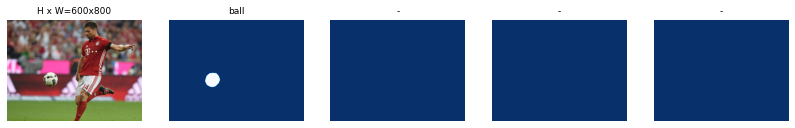

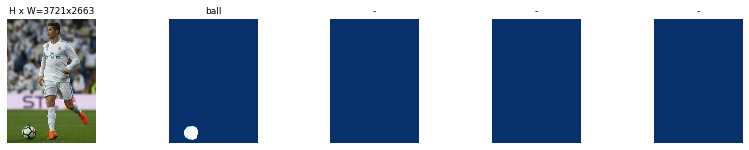

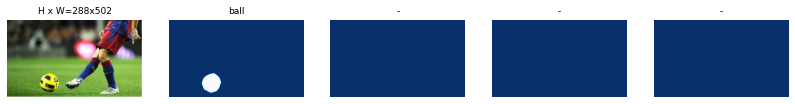

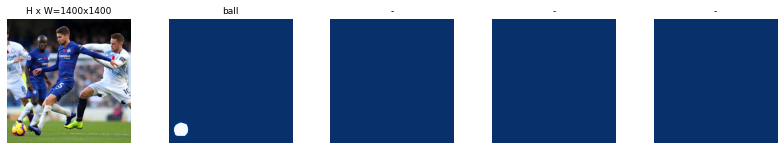

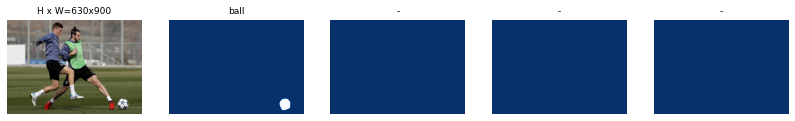

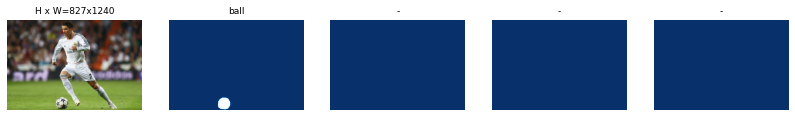

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids,6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Bounding Box(BB) with annotated ball mask 

Compute the bounding boxes from masks instead of using bounding box coordinates from input datasets to handle bounding boxes consistently

image_id  57 C:\Users\Alinware\Desktop\Mask_RCNN-master\dataset/train\62.jpg
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (720, 1280, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    1.00000  max:  909.00000  int32


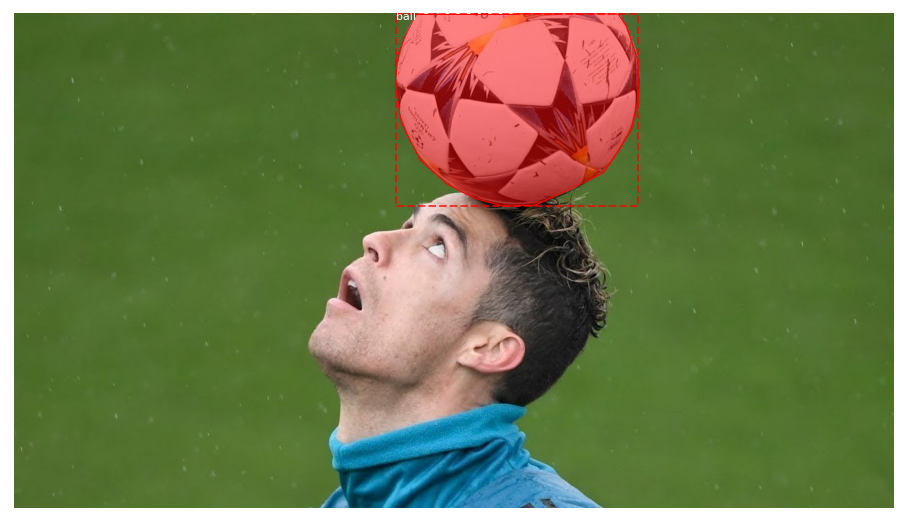

In [15]:
# Get BB and details of random image
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Load prepared annotation file which contains x and y co-ordinate of all labeled balls ('polygon') and class name('ball') for dataset

In [16]:
#Annotation file load
annotations1 = json.load(open(os.path.join(ROOT_DIR, "dataset/train/via_region_data.json"),encoding="utf8"))
annotations = list(annotations1.values()) 
annotations = [a for a in annotations if a['regions']]
annotations[0] #image2.jpg

{'fileref': '',
 'size': 78239,
 'filename': '2.jpg',
 'base64_img_data': '',
 'file_attributes': {},
 'regions': {'0': {'shape_attributes': {'name': 'polygon',
    'all_points_x': [402,
     409,
     416,
     424,
     438,
     455,
     474,
     485,
     489,
     490,
     485,
     479,
     471,
     450,
     428,
     419,
     405,
     400,
     400,
     402],
    'all_points_y': [342,
     331,
     323,
     315,
     312,
     312,
     322,
     334,
     350,
     366,
     376,
     385,
     387,
     389,
     390,
     390,
     371,
     355,
     345,
     342]},
   'region_attributes': {'ball': 'ball'}}}}

### Get coordinates for polygon of 2.jpg to calculate area of the marked/detected ball

In [17]:
annotations[1]['regions']['0']['shape_attributes']
l = []
for d in annotations[1]['regions']['0']['shape_attributes'].values():
    l.append(d)
display('x co-ordinates of the ball:',l[1])    
display('y co-ordinates of the ball:',l[2])

'x co-ordinates of the ball:'

[339,
 347,
 359,
 378,
 407,
 441,
 462,
 476,
 487,
 494,
 492,
 477,
 466,
 450,
 420,
 393,
 372,
 355,
 341,
 338,
 339]

'y co-ordinates of the ball:'

[549,
 520,
 499,
 484,
 475,
 479,
 490,
 503,
 523,
 551,
 581,
 598,
 613,
 625,
 628,
 627,
 614,
 598,
 577,
 559,
 549]

### ball detection/prediction 

In [8]:
# Use the model as inference mode.
config = custom.CustomConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on
DEVICE = "/cpu:0"  # /gpu:0

# Inspect the model in inference mode
TEST_MODE = "inference"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Helper function to visualize predicted ball masks

In [18]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

from importlib import reload
reload(visualize)

<module 'mrcnn.visualize' from 'C:\\Users\\Alinware\\Desktop\\Mask_RCNN-master\\mrcnn\\visualize.py'>

### Load model weights for prediction

In [19]:
# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last trained model
#weights_path = model.find_last()

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  C:/Users/Alinware/Desktop/Mask_RCNN-master/resnet101_weights_tf.h5


ValueError: Layer #2 (named "conv1") expects 2 weight(s), but the saved weights have 1 element(s).

## Inspect weights of the trained model

#### Visualize model weight matrix descriptive statistics(shapes, histograms)

In [11]:
# Review Weight Stats
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


#### Histograms of Weights

##### Perform a sanity check if weights and biases are properly distributed.

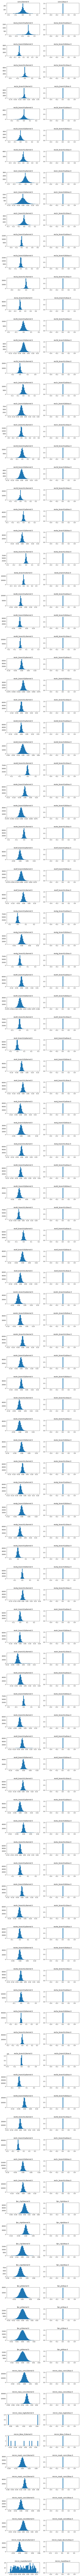

In [12]:
# layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']

# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

## Prediction on validation image

#### Load Validation Dataset

In [13]:
dataset = custom.CustomDataset()
dataset.load_custom(dataset_DIR,'val')
dataset.prepare()
print('Images: {}\nclasses: {}'.format(len(dataset.image_ids), dataset.class_names))

Images: 23
classes: ['BG', 'scratch']


image ID: scratch.image62.jpg (1) C:\Users\Alinware\car-damage-detector\dataset/val\image62.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  241.00000  max:  675.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
The car has:1 damage(s)


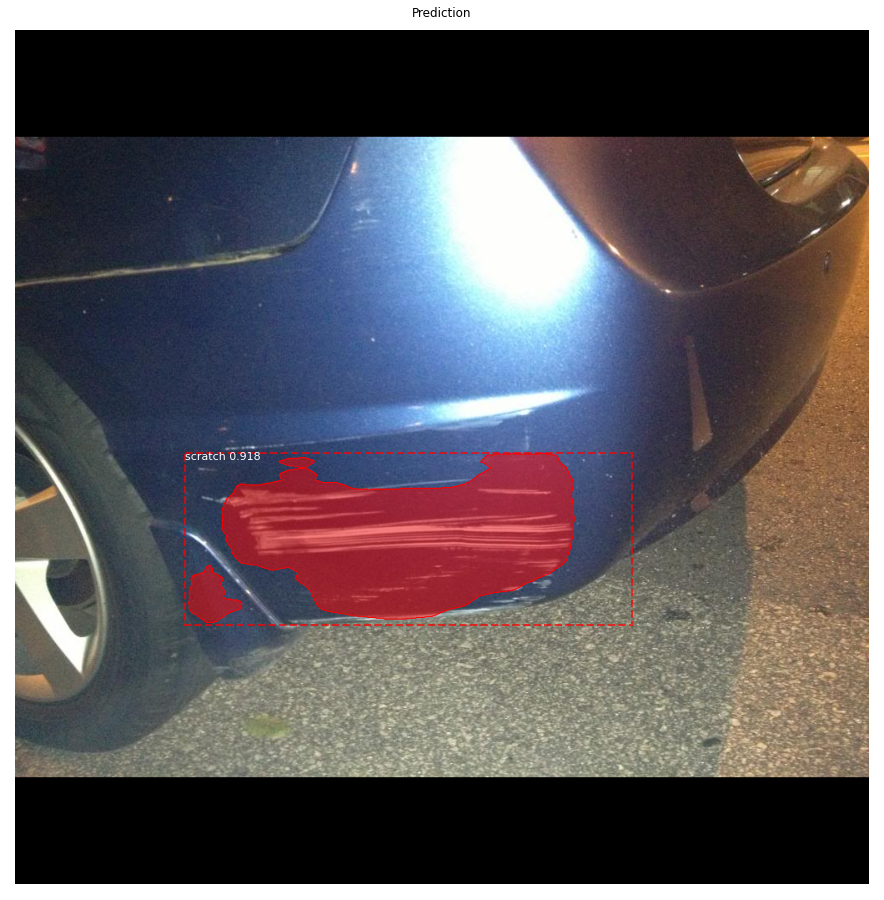

In [14]:
image_id = 1
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Prediction")
log("gt_class_id", gt_class_id)

log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print('ball(s)'.format(len(dataset.image_info[image_id]['polygons'])))

## Prediction on test image

Processing 1 images
image                    shape: (168, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  241.00000  max:  675.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
The car has:1 damage(s)


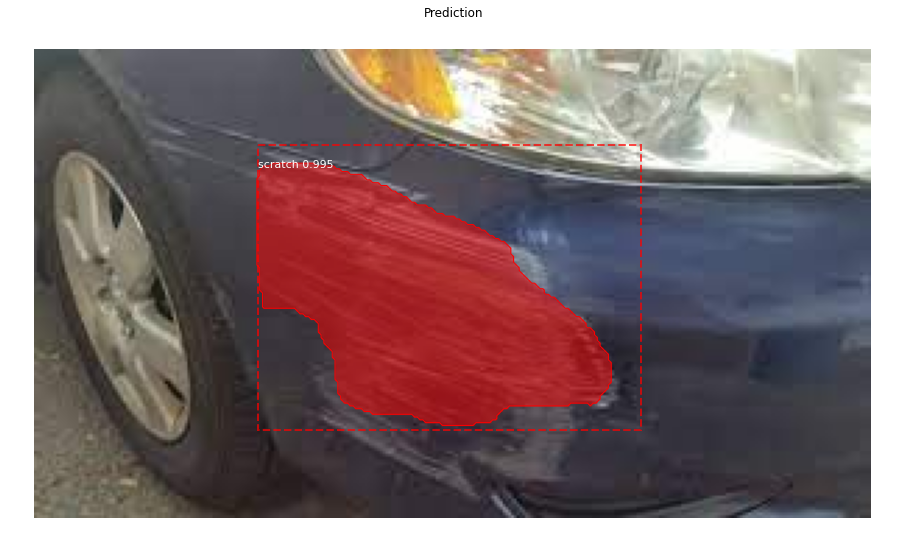

In [15]:
image = cv2.imread("C:/Users/Alinware/car-damage-detector/dataset/test/test7.jfif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Prediction")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print('ball(s)'.format(len(dataset.image_info[image_id]['polygons'])))                   